In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm.autonotebook import tqdm

import os
import numpy as np
import matplotlib.pyplot as plt

import utils as ut

plt.rcParams.update({'font.size': 12,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'legend.frameon':    False,})

%load_ext autoreload
%autoreload 2

/var/folders/q9/g15z8pxs2fd8tgyd9ggfv1c8x5w4qx/T/ipykernel_79956/198242598.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Synthetic data: Convolutional model vs GLM

## 1. Make synthetic data

In [ ]:
filename = "SSTindivsomata_GLM"
# filename = "NDNFindivsomata_GLM"
# filename = "EC_GLM"

filepath = os.path.join("datasets", filename+".mat")
activity_dict, factors_dict = ut.preprocess_data(filepath)

animal = 'animal_1'
velocity = factors_dict[animal]['Velocity']

activity, place_field, velocity_component, noise = ut.get_synthetic_data(activity_dict, velocity, 
                                                                        place_field_type='negative_ramp', place_field_scale=-1, place_field_shift=-10, 
                                                                        velocity_weight_type='flat', velocity_weight=1, velocity_power=1, 
                                                                        noise_scale=0)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

im = ax[0].imshow(place_field.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax[0])
ax[0].set_title('Place Field')
ax[0].set_xlabel('Position (cm)')
ax[0].set_ylabel('Trials')

im = ax[1].imshow(velocity.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax[1])
ax[1].set_title('Velocity')
ax[1].set_xlabel('Position (cm)')
ax[1].set_ylabel('Trials')

im = ax[2].imshow(activity.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax[2])
ax[2].set_title('Combined Activity')
ax[2].set_xlabel('Position (cm)')
ax[2].set_ylabel('Trials')
plt.tight_layout()
plt.show()

## 2. Train models

In [ ]:
# Train simple convolutional model
model = ut.ConvModel1D(kernel_size=25)
activity_pred = model.fit(velocity, activity, learning_rate=0.001, num_iterations=10_000, plot=True)
conv_prediction = activity_pred.reshape(velocity.shape)

plt.plot(model.conv1.weight.data[0,0])
plt.ylabel('Weight')
plt.title('Convolutional Kernel')

In [ ]:
# Train GLM for comparison
filtered_factors_dict = ut.subset_variables_from_data(factors_dict, variables_to_keep=["Velocity"])
GLM_params, neuron_predicted_activity = ut.fit_GLM(filtered_factors_dict[animal], activity, regression='linear')
GLM_prediction = neuron_predicted_activity.reshape(activity.shape)

In [ ]:

fig, ax = plt.subplots(2,4, figsize=(16,5))
im = ax[0,0].imshow(velocity.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,0])
ax[0,0].set_title('Velocity')
ax[1,0].plot(velocity.mean(axis=1), 'k')

im = ax[0,1].imshow(activity.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,1])
ax[0,1].set_title('Combined Activity')
ax[1,1].plot(activity.mean(axis=1), 'r')

im = ax[0,2].imshow(conv_prediction.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,2])
ax[0,2].set_title('Conv (1D) Prediction')
ax[1,2].plot(conv_prediction.mean(axis=1))
ax[1,2].plot(activity.mean(axis=1), '--r')

im = ax[0,3].imshow(GLM_prediction.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,3])
ax[0,3].set_title('GLM Prediction')
ax[1,3].plot(GLM_prediction.mean(axis=1))
ax[1,3].plot(activity.mean(axis=1), '--r')

plt.tight_layout()
plt.show()

conv_residual = activity - conv_prediction
conv_fit_MSE = np.mean(conv_residual**2)
glm_residual = activity - GLM_prediction
glm_fit_MSE = np.mean(glm_residual**2)
print(f"Convolutional Fit MSE: {conv_fit_MSE:.4f}")
print(f"GLM Fit MSE: {glm_fit_MSE:.4f}")
if conv_fit_MSE < glm_fit_MSE:
    print("Convolutional model is a better fit.")
else:
    print("GLM is a better fit.")

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

im = ax[0].imshow(place_field.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax[0])
ax[0].set_title('Place Field')
ax[0].set_xlabel('Position (cm)')
ax[0].set_ylabel('Trials')

im = ax[1].imshow(conv_residual.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax[1])
ax[1].set_title('Convolutional Residual')
ax[1].set_xlabel('Position (cm)')
ax[1].set_ylabel('Trials')

im = ax[2].imshow(glm_residual.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax[2])
ax[2].set_title('GLM Residual')
ax[2].set_xlabel('Position (cm)')
ax[2].set_ylabel('Trials')

plt.tight_layout()
plt.show()

conv_fit_vs_ground = np.mean((conv_residual - place_field)**2)
glm_fit_vs_ground = np.mean((glm_residual - place_field)**2)
print(f"Convolutional Fit vs Ground Truth MSE: {conv_fit_vs_ground:.4f}")
print(f"GLM Fit vs Ground Truth MSE: {glm_fit_vs_ground:.4f}")
if conv_fit_vs_ground < glm_fit_vs_ground:
    print("Convolutional model is a better fit.")
else:
    print("GLM is a better fit.")

In [ ]:
print(GLM_params['weights']['Velocity'], GLM_params['intercept'])

In [ ]:
print(torch.max(model.conv1.weight.data), model.conv1.bias.data)

# Real data: Convolutional model vs GLM

## 1. Load real data

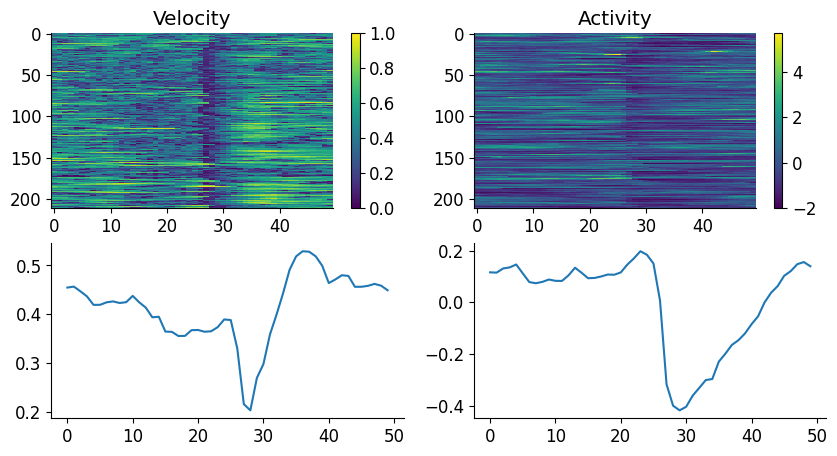

In [14]:
filename = "SSTindivsomata_GLM"
# filename = "NDNFindivsomata_GLM"
# filename = "EC_GLM"

filepath = os.path.join("datasets", filename+".mat")
activity_dict, factors_dict = ut.preprocess_data(filepath)

animal = 'animal_1'
cell = 'cell_2'

velocity = factors_dict[animal]['Velocity']
activity = activity_dict[animal][cell]
# activity = (activity - activity.min()) / (activity.max() - activity.min())
activity = (activity - activity.mean()) / activity.std()

fig, ax = plt.subplots(2,2, figsize=(10,5))
im = ax[0,0].imshow(velocity.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,0])
ax[0,0].set_title('Velocity')
im = ax[0,1].imshow(activity.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,1])
ax[0,1].set_title('Activity')
ax[1,0].plot(velocity.mean(axis=1))
ax[1,1].plot(activity.mean(axis=1))

## 2. Train simple 1D conv model

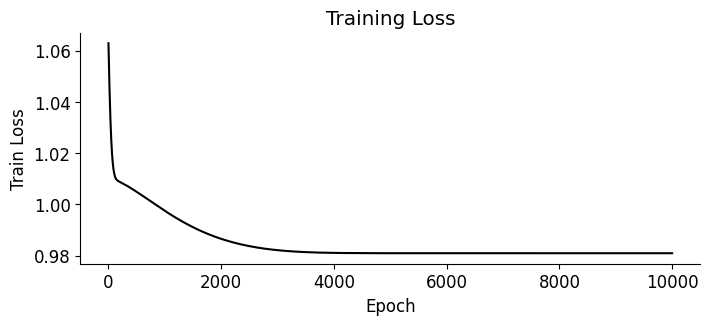

Text(0.5, 1.0, 'Convolutional Kernel')

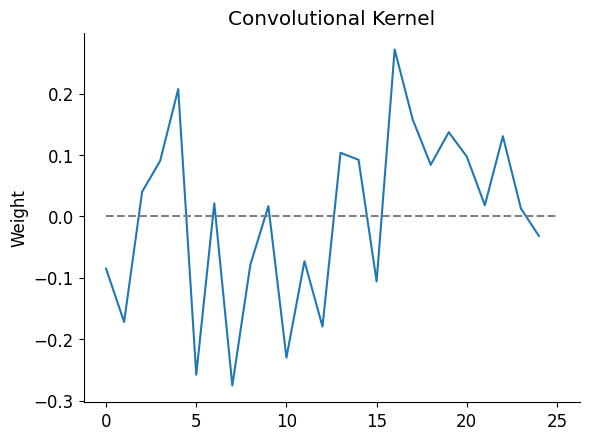

In [16]:
# Train simple convolutional model
kernel_size = 25
model = ut.ConvModel1D(kernel_size=kernel_size)
activity_pred = model.fit(velocity, activity, learning_rate=0.0002, num_iterations=10_000, plot=True)
conv_prediction = activity_pred.reshape(velocity.shape)

plt.plot(model.conv1.weight.data[0,0])
plt.hlines(0,0, kernel_size, color='gray', linestyle='--')
plt.ylabel('Weight')
plt.title('Convolutional Kernel')

In [20]:
# Train GLM for comparison
filtered_factors_dict = ut.subset_variables_from_data(factors_dict, variables_to_keep=["Velocity"])
GLM_params, neuron_predicted_activity = ut.fit_GLM(filtered_factors_dict[animal], activity, regression='linear')
GLM_prediction = neuron_predicted_activity.reshape(activity.shape)

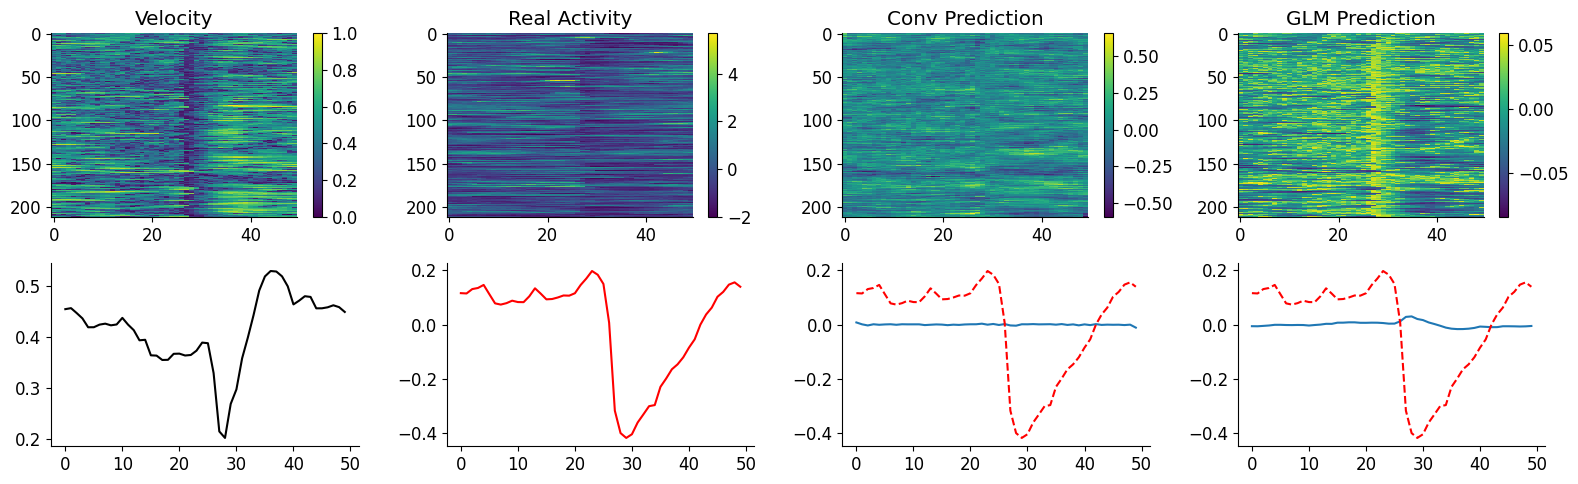

Convolutional Fit MSE: 0.9810
GLM Fit MSE: 0.9992
Convolutional model is a better fit.


In [21]:
fig, ax = plt.subplots(2,4, figsize=(16,5))
im = ax[0,0].imshow(velocity.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,0])
ax[0,0].set_title('Velocity')
ax[1,0].plot(velocity.mean(axis=1), 'k')

im = ax[0,1].imshow(activity.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,1])
ax[0,1].set_title('Real Activity')
ax[1,1].plot(activity.mean(axis=1), 'r')

im = ax[0,2].imshow(conv_prediction.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,2])
ax[0,2].set_title('Conv Prediction')
ax[1,2].plot(conv_prediction.mean(axis=1))
ax[1,2].plot(activity.mean(axis=1), '--r')

im = ax[0,3].imshow(GLM_prediction.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,3])
ax[0,3].set_title('GLM Prediction')
ax[1,3].plot(GLM_prediction.mean(axis=1))
ax[1,3].plot(activity.mean(axis=1), '--r')
plt.tight_layout()
plt.show()

conv_residual = activity - conv_prediction
conv_fit_MSE = np.mean(conv_residual**2)
glm_residual = activity - GLM_prediction
glm_fit_MSE = np.mean(glm_residual**2)
print(f"Convolutional Fit MSE: {conv_fit_MSE:.4f}")
print(f"GLM Fit MSE: {glm_fit_MSE:.4f}")
if conv_fit_MSE < glm_fit_MSE:
    print("Convolutional model is a better fit.")
else:
    print("GLM is a better fit.")

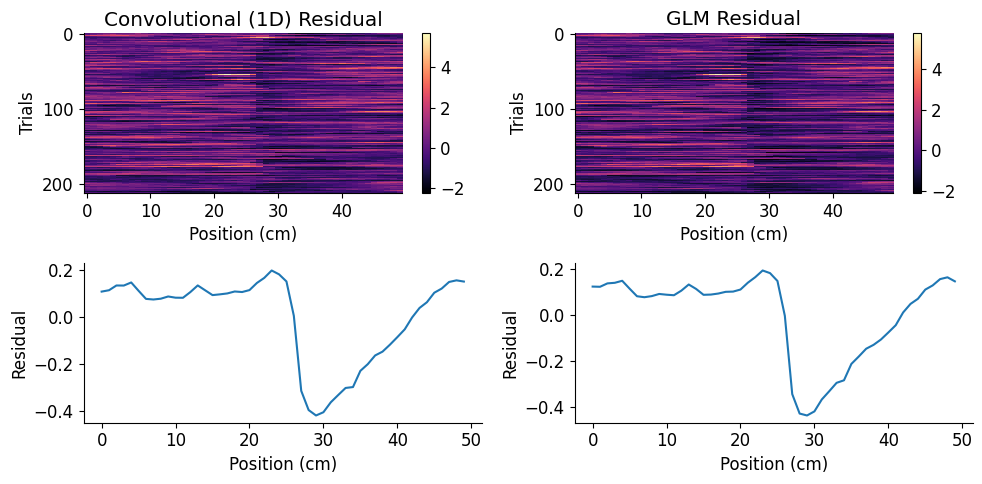

In [22]:
fig, axes = plt.subplots(2,2, figsize=(10,5))

ax = axes[0,0]
im = ax.imshow(conv_residual.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax)
ax.set_title('Convolutional (1D) Residual')
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Trials')
ax = axes[1,0]
ax.plot(conv_residual.mean(axis=1))
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Residual')

ax = axes[0,1]
im = ax.imshow(glm_residual.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax)
ax.set_title('GLM Residual')
ax.set_xlabel('Position (cm)')  
ax.set_ylabel('Trials')
ax = axes[1,1]
ax.plot(glm_residual.mean(axis=1))
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Residual')

plt.tight_layout()
plt.show()


## 2.1 Train 2D convolutional model

In [ ]:
# Train simple convolutional model
kernel_width = 25
kernel_height = 9
model = ut.ConvModel2D(kernel_width=kernel_width, kernel_height=kernel_height)
activity_pred = model.fit(velocity, activity, learning_rate=0.0002, num_iterations=10_000, plot=True)
conv2D_prediction = activity_pred

In [ ]:
fig, ax = plt.subplots(figsize=(5,1))
color_scale = torch.max(torch.abs(model.conv1.weight.data[0,0]))
im = ax.imshow(model.conv1.weight.data[0,0], aspect='equal', cmap='bwr', vmin=-color_scale, vmax=color_scale)
cax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
cbar = plt.colorbar(im, cax=cax)
box = ax.add_patch(plt.Rectangle((kernel_width/2-1,kernel_height/2-1),1,1,fill=False,edgecolor='k',linewidth=1.5))
plt.show()

In [ ]:
fig, ax = plt.subplots(2,4, figsize=(16,5))
im = ax[0,0].imshow(velocity.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,0])
ax[0,0].set_title('Velocity')
ax[1,0].plot(velocity.mean(axis=1), 'k')

im = ax[0,1].imshow(activity.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,1])
ax[0,1].set_title('Real Activity')
ax[1,1].plot(activity.mean(axis=1), 'r')

im = ax[0,2].imshow(conv2D_prediction.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,2])
ax[0,2].set_title('Conv 2D Prediction')
ax[1,2].plot(conv_prediction.mean(axis=1))
ax[1,2].plot(activity.mean(axis=1), '--r')

im = ax[0,3].imshow(GLM_prediction.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,3])
ax[0,3].set_title('GLM Prediction')
ax[1,3].plot(GLM_prediction.mean(axis=1))
ax[1,3].plot(activity.mean(axis=1), '--r')
plt.tight_layout()
plt.show()

conv2D_residual = activity - conv2D_prediction
conv2D_fit_MSE = np.mean(conv2D_residual**2)
glm_residual = activity - GLM_prediction
glm_fit_MSE = np.mean(glm_residual**2)
print(f"Convolutional (1D) Fit MSE: {conv_fit_MSE:.14f}")
print(f"Convolutional (2D) Fit MSE: {conv2D_fit_MSE:.14f}")
print(f"GLM Fit MSE: {glm_fit_MSE:.5f}")
if conv2D_fit_MSE < glm_fit_MSE:
    print("2DConvolutional model is a better fit than GLM.")
    if conv2D_fit_MSE < conv_fit_MSE:
        print("2DConvolutional model is a better fit than 1DConvolutional model.")
else:
    print("GLM is a better fit.")

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(15,5))

ax = axes[0,0]
im = ax.imshow(conv_residual.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax)
ax.set_title('Convolutional (1D) Residual')
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Trials')
ax = axes[1,0]
ax.plot(conv_residual.mean(axis=1))
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Residual')

ax = axes[0,1]
im = ax.imshow(glm_residual.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax)
ax.set_title('GLM Residual')
ax.set_xlabel('Position (cm)')  
ax.set_ylabel('Trials')
ax = axes[1,1]
ax.plot(glm_residual.mean(axis=1))
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Residual')

ax = axes[0,2]
im = ax.imshow(conv2D_residual.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax)
ax.set_title('Convolutional (2D) Residual')
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Trials')
ax = axes[1,2]
ax.plot(conv2D_residual.mean(axis=1))
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Residual')

plt.tight_layout()
plt.show()


## Train 1D conv model on all cells

### GLM vs Conv1D: SST Cells

In [95]:
filename = "SSTindivsomata_GLM"

filepath = os.path.join("datasets", filename+".mat")
activity_dict, factors_dict = ut.preprocess_data(filepath)

# Train one 1D convolutional model for each cell
all_kernels = []
all_losses = []
fit_MSE = {'conv1D':[] , 'GLM':[]}

filtered_factors_dict = ut.subset_variables_from_data(factors_dict, variables_to_keep=["Velocity"])

# fig, ax = plt.subplots(1,1, figsize=(10,3))
for animal in activity_dict:
# animal = 'animal_1'

    velocity = factors_dict[animal]['Velocity']
    for cell in activity_dict[animal]:
        print(f'{animal} {cell}')
        activity = activity_dict[animal][cell]
        activity = (activity - activity.mean()) / activity.std()
        
        kernel_size = 25
        model = ut.ConvModel1D(kernel_size=kernel_size)
        activity_pred = model.fit(velocity, activity, learning_rate=0.0004, num_iterations=6_000, plot=False)
        all_losses.append(model.train_loss)
        conv_prediction = activity_pred.reshape(velocity.shape)

        all_kernels.append(model.conv1.weight.data[0,0])

        # Train GLM for comparison
        GLM_params, neuron_predicted_activity = ut.fit_GLM(filtered_factors_dict[animal], activity, regression='linear')
        GLM_prediction = neuron_predicted_activity.reshape(activity.shape)

        conv_residual = activity - conv_prediction
        conv_fit_MSE = np.mean(conv_residual**2)
        glm_residual = activity - GLM_prediction
        glm_fit_MSE = np.mean(glm_residual**2)
        # print(f'conv1D MSE: {conv_fit_MSE}')
        # print(f'GLM MSE: {glm_fit_MSE}')

        fit_MSE['conv1D'].append(conv_fit_MSE)
        fit_MSE['GLM'].append(glm_fit_MSE)

animal_1 cell_2
animal_1 cell_3
animal_1 cell_4
animal_1 cell_5
animal_1 cell_6
animal_2 cell_2
animal_2 cell_3
animal_2 cell_4
animal_2 cell_5
animal_2 cell_6
animal_2 cell_7
animal_2 cell_8
animal_2 cell_9
animal_2 cell_10
animal_2 cell_11
animal_2 cell_12
animal_2 cell_13
animal_2 cell_14
animal_2 cell_15
animal_2 cell_16
animal_3 cell_2
animal_3 cell_3
animal_3 cell_4
animal_3 cell_5
animal_3 cell_6
animal_3 cell_7
animal_4 cell_2
animal_4 cell_3
animal_4 cell_4
animal_4 cell_5
animal_5 cell_2
animal_5 cell_3
animal_5 cell_4
animal_5 cell_5
animal_5 cell_6
animal_5 cell_7
animal_5 cell_8
animal_5 cell_9
animal_5 cell_10
animal_5 cell_11
animal_5 cell_12
animal_5 cell_13
animal_5 cell_14
animal_6 cell_2
animal_6 cell_3
animal_6 cell_4
animal_6 cell_5
animal_6 cell_6
animal_6 cell_7
animal_6 cell_8
animal_6 cell_9
animal_6 cell_10
animal_6 cell_11
animal_6 cell_12
animal_6 cell_13
animal_6 cell_14
animal_7 cell_2
animal_7 cell_3
animal_7 cell_4
animal_8 cell_2
animal_8 cell_3
animal_

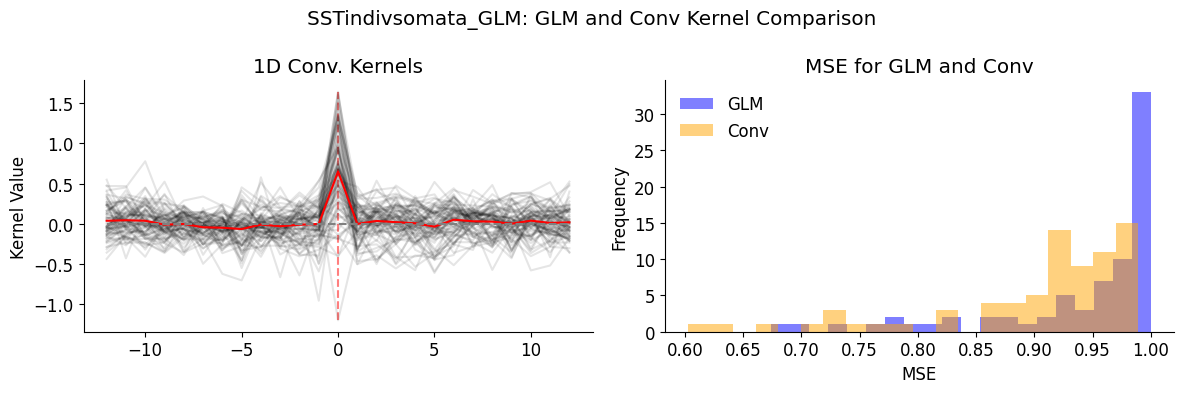

In [96]:
kernels = np.array(all_kernels)

fig, axes = plt.subplots(1,2, figsize=(12, 4))
ax = axes[0]
ax.vlines(0, kernels.min(), kernels.max(), color='r', linestyle='--', alpha=0.5)
ax.plot(range(-12,13), kernels.T, 'k', alpha=0.1)
ax.plot(range(-12,13),kernels.mean(axis=0), 'r')
ax.hlines(0, -12, 12, color='gray', linestyle='--')
ax.set_ylabel('Kernel Value')
ax.set_title(f'1D Conv. Kernels')

ax = axes[1]
n_bins = 20
ax.hist(fit_MSE['GLM'], bins=n_bins, alpha=0.5, label='GLM', color='blue')
ax.hist(fit_MSE['conv1D'], bins=n_bins, alpha=0.5, label='Conv', color='orange')
ax.legend()
ax.set_xlabel('MSE')
ax.set_ylabel('Frequency')
ax.set_title(f'MSE for GLM and Conv')

fig.suptitle(f'{filename}: GLM and Conv Kernel Comparison')
plt.tight_layout()
plt.show()

### GLM vs Conv1D: NDNF Cells

In [ ]:
filename = "NDNFindivsomata_GLM"

filepath = os.path.join("datasets", filename+".mat")
activity_dict, factors_dict = ut.preprocess_data(filepath)

# Train one 1D convolutional model for each cell
all_kernels = []
all_losses = []
fit_MSE = {'conv1D':[] , 'GLM':[]}

filtered_factors_dict = ut.subset_variables_from_data(factors_dict, variables_to_keep=["Velocity"])

# fig, ax = plt.subplots(1,1, figsize=(10,3))
for animal in activity_dict:
# animal = 'animal_1'

    velocity = factors_dict[animal]['Velocity']
    for cell in activity_dict[animal]:
        print(f'{animal} {cell}')
        activity = activity_dict[animal][cell]
        activity = (activity - activity.mean()) / activity.std()
        
        kernel_size = 25
        model = ut.ConvModel1D(kernel_size=kernel_size)
        activity_pred = model.fit(velocity, activity, learning_rate=0.0004, num_iterations=6_000, plot=False)
        all_losses.append(model.train_loss)
        conv_prediction = activity_pred.reshape(velocity.shape)

        all_kernels.append(model.conv1.weight.data[0,0])

        # Train GLM for comparison
        GLM_params, neuron_predicted_activity = ut.fit_GLM(filtered_factors_dict[animal], activity, regression='linear')
        GLM_prediction = neuron_predicted_activity.reshape(activity.shape)

        conv_residual = activity - conv_prediction
        conv_fit_MSE = np.mean(conv_residual**2)
        glm_residual = activity - GLM_prediction
        glm_fit_MSE = np.mean(glm_residual**2)
        # print(f'conv1D MSE: {conv_fit_MSE}')
        # print(f'GLM MSE: {glm_fit_MSE}')

        fit_MSE['conv1D'].append(conv_fit_MSE)
        fit_MSE['GLM'].append(glm_fit_MSE)

animal_1 cell_2
animal_1 cell_3
animal_1 cell_4
animal_1 cell_5
animal_1 cell_6
animal_1 cell_7
animal_1 cell_8
animal_1 cell_9
animal_1 cell_10
animal_1 cell_11
animal_1 cell_12
animal_1 cell_13
animal_1 cell_14
animal_1 cell_15
animal_2 cell_2
animal_2 cell_3
animal_2 cell_4
animal_2 cell_5
animal_2 cell_6
animal_2 cell_7
animal_2 cell_8
animal_2 cell_9
animal_2 cell_10
animal_2 cell_11
animal_2 cell_12
animal_2 cell_13
animal_2 cell_14
animal_2 cell_15
animal_3 cell_2
animal_3 cell_3
animal_3 cell_4
animal_3 cell_5
animal_3 cell_6
animal_3 cell_7
animal_4 cell_2
animal_4 cell_3
animal_4 cell_4
animal_4 cell_5
animal_4 cell_6
animal_4 cell_7
animal_4 cell_8
animal_4 cell_9
animal_4 cell_10
animal_4 cell_11
animal_4 cell_12


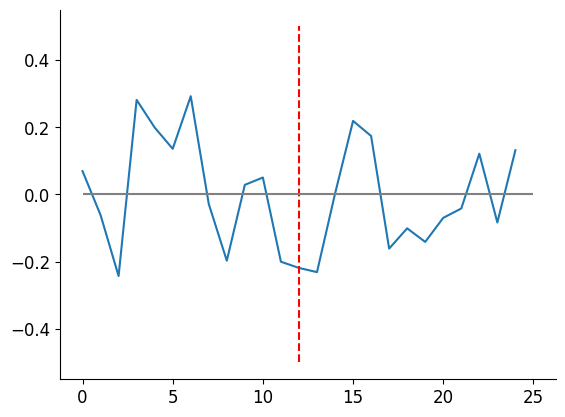

In [ ]:
kernels = np.array(all_kernels)
plt.plot(kernels[3])
plt.vlines(kernel_size//2, -0.5, 0.5, color='r', linestyle='--')
plt.hlines(0, 0, kernel_size, color='gray', linestyle='-')

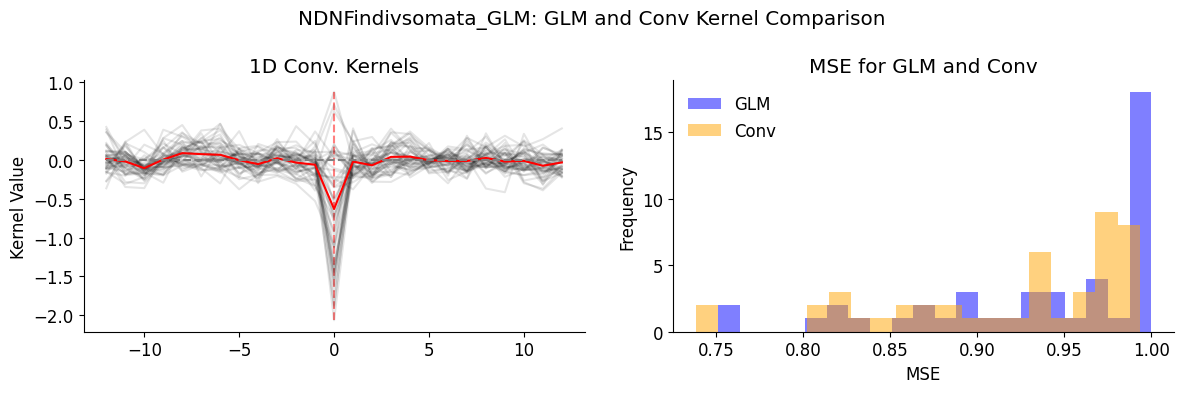

In [ ]:
kernels = np.array(all_kernels)

fig, axes = plt.subplots(1,2, figsize=(12, 4))
ax = axes[0]
ax.vlines(0, kernels.min(), kernels.max(), color='r', linestyle='--', alpha=0.5)
ax.plot(range(-12,13), kernels.T, 'k', alpha=0.1)
ax.plot(range(-12,13),kernels.mean(axis=0), 'r')
ax.hlines(0, -12, 12, color='gray', linestyle='--')
ax.set_ylabel('Kernel Value')
ax.set_title(f'1D Conv. Kernels')

ax = axes[1]
n_bins = 20
ax.hist(fit_MSE['GLM'], bins=n_bins, alpha=0.5, label='GLM', color='blue')
ax.hist(fit_MSE['conv1D'], bins=n_bins, alpha=0.5, label='Conv', color='orange')
ax.legend()
ax.set_xlabel('MSE')
ax.set_ylabel('Frequency')
ax.set_title(f'MSE for GLM and Conv')

fig.suptitle(f'{filename}: GLM and Conv Kernel Comparison')
plt.tight_layout()
plt.show()

### GLM vs Conv1D: EC Cells (Axons)

In [97]:
filename = "EC_GLM"

filepath = os.path.join("datasets", filename+".mat")
activity_dict, factors_dict = ut.preprocess_data(filepath)

# Train one 1D convolutional model for each cell
all_kernels = []
all_losses = []
fit_MSE = {'conv1D':[] , 'GLM':[]}

filtered_factors_dict = ut.subset_variables_from_data(factors_dict, variables_to_keep=["Velocity"])

# fig, ax = plt.subplots(1,1, figsize=(10,3))
for animal in activity_dict:
# animal = 'animal_1'

    velocity = factors_dict[animal]['Velocity']
    for cell in activity_dict[animal]:
        print(f'{animal} {cell}')
        activity = activity_dict[animal][cell]
        activity = (activity - activity.mean()) / activity.std()
        
        kernel_size = 25
        model = ut.ConvModel1D(kernel_size=kernel_size)
        activity_pred = model.fit(velocity, activity, learning_rate=0.0004, num_iterations=6_000, plot=False)
        all_losses.append(model.train_loss)
        conv_prediction = activity_pred.reshape(velocity.shape)

        all_kernels.append(model.conv1.weight.data[0,0])

        # Train GLM for comparison
        GLM_params, neuron_predicted_activity = ut.fit_GLM(filtered_factors_dict[animal], activity, regression='linear')
        GLM_prediction = neuron_predicted_activity.reshape(activity.shape)

        conv_residual = activity - conv_prediction
        conv_fit_MSE = np.mean(conv_residual**2)
        glm_residual = activity - GLM_prediction
        glm_fit_MSE = np.mean(glm_residual**2)
        # print(f'conv1D MSE: {conv_fit_MSE}')
        # print(f'GLM MSE: {glm_fit_MSE}')

        fit_MSE['conv1D'].append(conv_fit_MSE)
        fit_MSE['GLM'].append(glm_fit_MSE)

animal_1 cell_1
animal_1 cell_2
animal_1 cell_3
animal_1 cell_4
animal_1 cell_5
animal_1 cell_6
animal_1 cell_7
animal_1 cell_8
animal_1 cell_9
animal_1 cell_10
animal_1 cell_11
animal_1 cell_12
animal_1 cell_13
animal_1 cell_14
animal_1 cell_15
animal_1 cell_16
animal_1 cell_17
animal_1 cell_18
animal_1 cell_19
animal_1 cell_20
animal_1 cell_21
animal_1 cell_22
animal_1 cell_23
animal_1 cell_24
animal_1 cell_25
animal_1 cell_26
animal_1 cell_27
animal_1 cell_28
animal_1 cell_29
animal_1 cell_30
animal_1 cell_31
animal_1 cell_32
animal_1 cell_33
animal_1 cell_34
animal_1 cell_35
animal_1 cell_36
animal_1 cell_37
animal_1 cell_38
animal_1 cell_39
animal_1 cell_40
animal_1 cell_41
animal_1 cell_42
animal_1 cell_43
animal_1 cell_44
animal_1 cell_45
animal_1 cell_46
animal_1 cell_47
animal_1 cell_48
animal_1 cell_49
animal_1 cell_50
animal_1 cell_51
animal_1 cell_52
animal_1 cell_53
animal_1 cell_54
animal_1 cell_55
animal_1 cell_56
animal_1 cell_57
animal_1 cell_58
animal_1 cell_59
animal

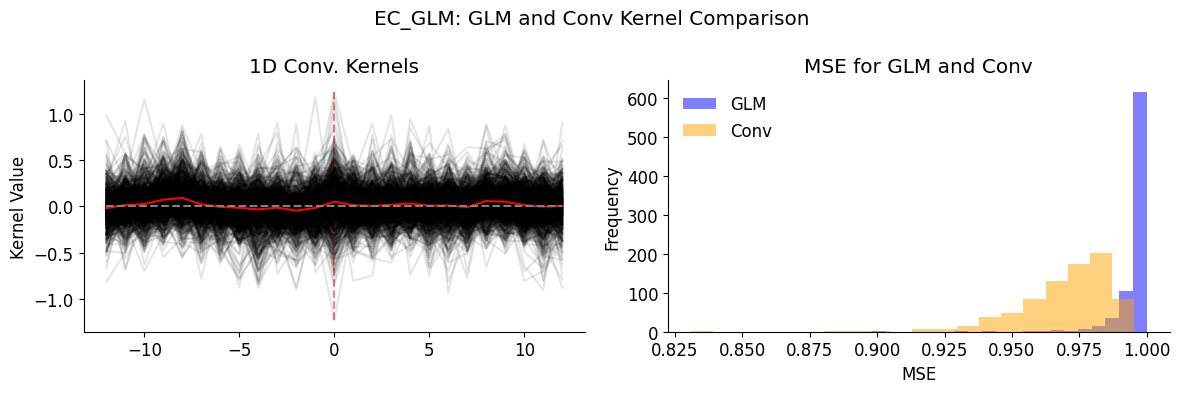

In [98]:
kernels = np.array(all_kernels)

fig, axes = plt.subplots(1,2, figsize=(12, 4))
ax = axes[0]
ax.vlines(0, kernels.min(), kernels.max(), color='r', linestyle='--', alpha=0.5)
ax.plot(range(-12,13), kernels.T, 'k', alpha=0.1)
ax.plot(range(-12,13),kernels.mean(axis=0), 'r')
ax.hlines(0, -12, 12, color='gray', linestyle='--')
ax.set_ylabel('Kernel Value')
ax.set_title(f'1D Conv. Kernels')

ax = axes[1]
n_bins = 20
ax.hist(fit_MSE['GLM'], bins=n_bins, alpha=0.5, label='GLM', color='blue')
ax.hist(fit_MSE['conv1D'], bins=n_bins, alpha=0.5, label='Conv', color='orange')
ax.legend()
ax.set_xlabel('MSE')
ax.set_ylabel('Frequency')
ax.set_title(f'MSE for GLM and Conv')

fig.suptitle(f'{filename}: GLM and Conv Kernel Comparison')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, '1D Conv. Kernel: EC cell 138')

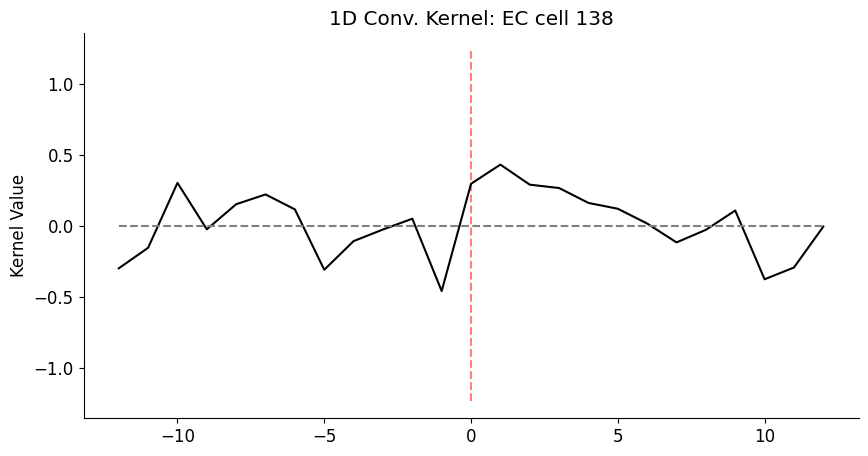

In [ ]:
# 24, 101, 138
fig, ax = plt.subplots(figsize=(10, 5))
ax.vlines(0, kernels.min(), kernels.max(), color='r', linestyle='--', alpha=0.5)
ax.plot(range(-12,13), kernels[138], 'k', alpha=1)
ax.hlines(0, -12, 12, color='gray', linestyle='--')
ax.set_ylabel('Kernel Value')
ax.set_title(f'1D Conv. Kernel: EC cell 138')

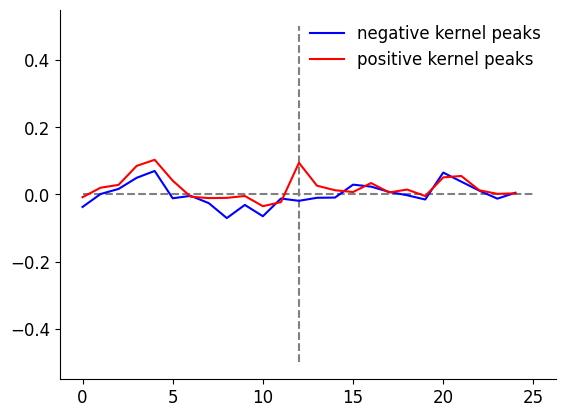

In [281]:
negative_kernels = kernels[negative_idx]
positive_kernels = kernels[positive_idx]


plt.hlines(0, 0, kernel_size, color='gray', linestyle='--')
plt.vlines(kernel_size//2, -0.5, 0.5, color='gray', linestyle='--')
plt.plot(negative_kernels.mean(axis=0), 'b', label='negative kernel peaks')
plt.plot(positive_kernels.mean(axis=0), 'r', label='positive kernel peaks')
plt.legend()


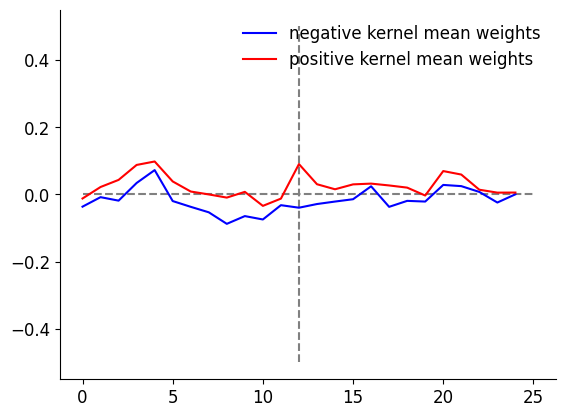

In [283]:
avg_vals = np.mean(kernels, axis=1)
negative_idx = np.where(avg_vals < 0)[0]
positive_idx = np.where(avg_vals > 0)[0]
negative_kernels = kernels[negative_idx]
positive_kernels = kernels[positive_idx]

plt.hlines(0, 0, kernel_size, color='gray', linestyle='--')
plt.vlines(kernel_size//2, -0.5, 0.5, color='gray', linestyle='--')
plt.plot(negative_kernels.mean(axis=0), 'b', label='negative kernel mean weights')
plt.plot(positive_kernels.mean(axis=0), 'r', label='positive kernel mean weights')
plt.legend()
